In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"watering_dataset.csv")
df.sample(5)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   soil_moisture        1500 non-null   float64
 1   temperature          1500 non-null   float64
 2   humidity             1500 non-null   float64
 3   light_hours          1500 non-null   float64
 4   days_since_watering  1500 non-null   int64  
 5   plant_type           1500 non-null   object 
 6   label                1500 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 82.2+ KB


,soil_moisture,temperature,humidity,light_hours,days_since_watering
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,46.216470,24.815198,49.313091,7.925254,2.259333
std,12.846191,5.666901,17.002395,2.333639,2.121418
min,13.897520,15.053321,20.025637,4.012904,0.000000
25%,39.388863,19.937925,34.806321,5.890632,1.000000
50%,48.031899,24.507057,48.628217,7.808713,2.000000
75%,55.207109,29.608726,63.811172,10.016868,3.000000
max,75.873576,34.999051,79.974711,11.994473,10.000000


In [3]:
df.value_counts("label")

label
Skip              757
Water_Tomorrow    406
Water_Today       337
Name: count, dtype: int64

## NOW LABELS ARE BALANCES AND WORHTY OF USING 
### since the data is fairly distributed after synthesizing the dataset 

In [4]:
df.drop(columns= ['plant_type'], inplace= True)
X = df[['soil_moisture', 'temperature', 'humidity', 'light_hours', 'days_since_watering']]
y = df.label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded = le.fit_transform(y)

df = pd.concat([X, pd.DataFrame({'label': y_encoded})], axis = 1)
df.sample(5)

,soil_moisture,temperature,humidity,light_hours,days_since_watering,label
839,18.576582,32.261515,43.033674,10.489192,7,1
1450,54.784791,31.505852,77.588277,11.170911,1,0
129,46.457934,22.517152,60.429331,10.569865,1,0
1439,51.157368,34.614742,52.771539,5.491417,1,2
788,23.770530,24.903727,39.153557,4.627029,7,2


<Axes: >

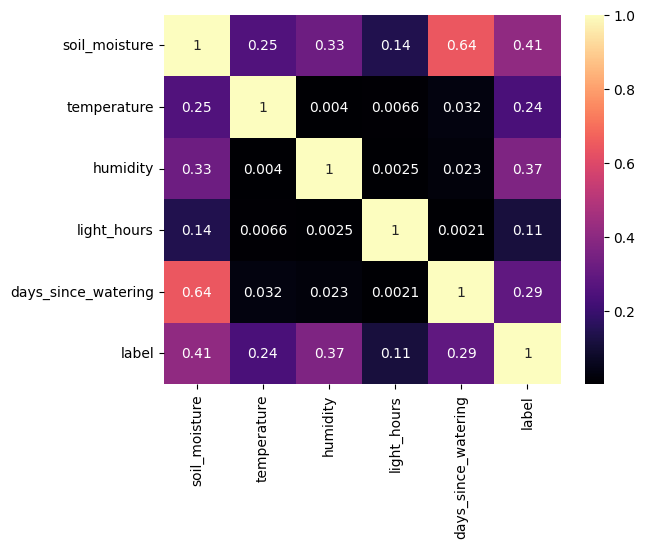

In [5]:
sns.heatmap(abs(df.corr()) , cmap = 'magma', annot= True)

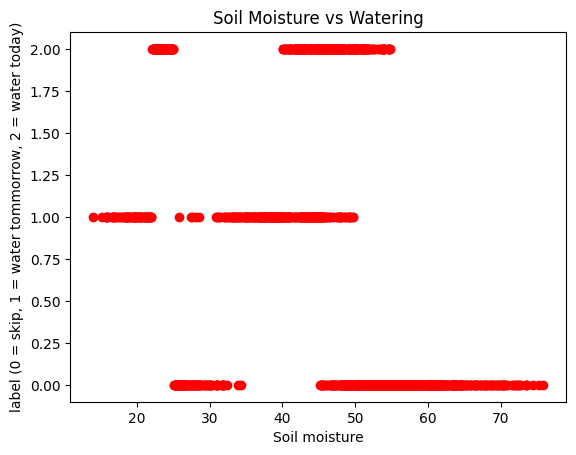

In [6]:
plt.scatter(X.soil_moisture, y_encoded, color = 'red')
plt.xlabel("Soil moisture")
plt.ylabel("label (0 = skip, 1 = water tommorrow, 2 = water today)")
plt.title("Soil Moisture vs Watering")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify = y)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf = RandomForestClassifier(
    n_estimators=200, 
    random_state= 42
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

          Skip       0.89      0.95      0.92       151
   Water_Today       0.92      0.87      0.89        68
Water_Tomorrow       0.78      0.73      0.75        81

      accuracy                           0.87       300
     macro avg       0.86      0.85      0.86       300
  weighted avg       0.87      0.87      0.87       300



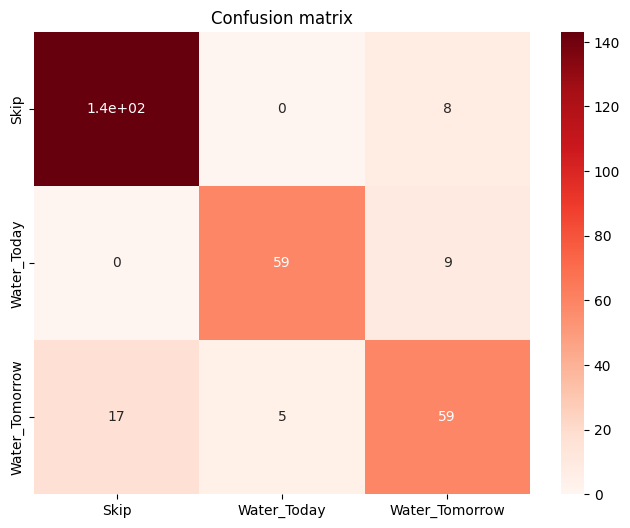

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot= True, cmap = 'Reds', xticklabels= le.classes_, yticklabels= le.classes_)
plt.title("Confusion matrix")
plt.show()

In [10]:
print(accuracy_score(y_test, y_pred))

0.87


## AS WE CAN SEE IT MISCLASIFIES ALOT OF THE WATER TOMORROW 
### yet seems pretty accurate on the skip label which i think is because the skip label is more redundant in the dataset thats why
### the model trained pretty well on it
#### now ill find the best hyperparameters using gridsearch

In [11]:
param_grid = {
    'n_estimators' : [300, 400, 500],
    'max_depth' : [10, 15],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [2, 4],
    'class_weight' : [None, 'balanced']
}

In [12]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

# Perform grid search with cross-validation
grid_search_model = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv = cv,
    scoring= "f1_weighted",
    verbose= 2
)

grid_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=40

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': [None, 'balanced'], 'max_depth': [10, 15], 'min_samples_leaf': [2, 4], 'min_samples_split': [5, 10], ...}"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [13]:
print(grid_search_model.best_params_)

{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}


In [14]:
rf_optimized = RandomForestClassifier(
    n_estimators= 400,
    class_weight= None,
    max_depth= 10,
    min_samples_leaf= 2,
    min_samples_split= 5,
)

rf_optimized.fit(X_train, y_train)
y_pred = rf_optimized.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

          Skip       0.89      0.95      0.92       151
   Water_Today       0.94      0.85      0.89        68
Water_Tomorrow       0.78      0.74      0.76        81

      accuracy                           0.87       300
     macro avg       0.87      0.85      0.86       300
  weighted avg       0.87      0.87      0.87       300



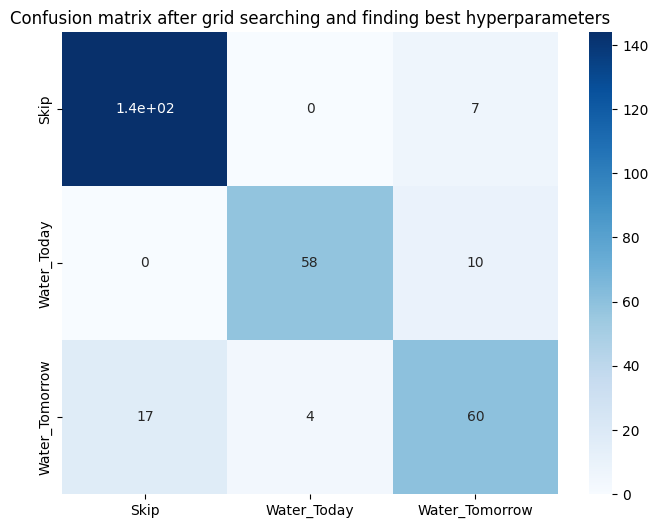

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = 'Blues', annot = True, xticklabels= le.classes_, yticklabels= le.classes_)
plt.title("Confusion matrix after grid searching and finding best hyperparameters")
plt.show()

In [16]:
print(accuracy_score(y_test, y_pred))

0.8733333333333333


In [17]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train)

X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [18]:
rf_optimized2 = RandomForestClassifier(
    n_estimators= 400,
    class_weight= None,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
)

rf_optimized2.fit(X_train_scaled, y_train)
y_pred = rf_optimized2.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

          Skip       0.90      0.94      0.92       151
   Water_Today       0.92      0.85      0.89        68
Water_Tomorrow       0.76      0.74      0.75        81

      accuracy                           0.87       300
     macro avg       0.86      0.84      0.85       300
  weighted avg       0.87      0.87      0.87       300



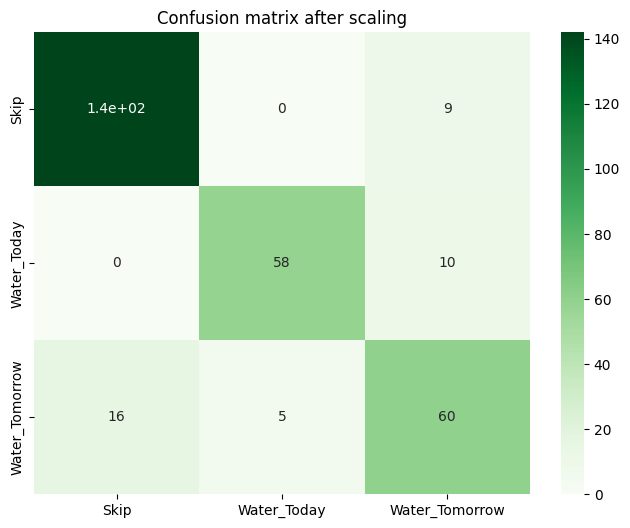

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = 'Greens', annot = True, xticklabels= le.classes_, yticklabels= le.classes_)
plt.title("Confusion matrix after scaling")
plt.show()

In [20]:
print(accuracy_score(y_test, y_pred))

0.8666666666666667


### Scaling is usually not needed in random forests because entropy and gini impurity dont get 
### that much affected by the scales of the values however since we somehow got a 0.07 increase
### we will have to go with it

In [21]:
input_data = pd.DataFrame([[26, 31, 48, 12, 4]], columns=['soil_moisture', 'temperature', 'humidity', 'light_hours', 'days_since_watering'])

pred1 = rf_optimized.predict(input_data)
pred2 = rf_optimized2.predict(scalar.transform(input_data))

print(f"Prediction without scaling: {pred1}")
print(f"Prediction with scaling: {pred2}")

Prediction without scaling: ['Water_Today']
Prediction with scaling: ['Water_Today']


## Now i'll save the model as pmml file 
## to use it load and use it later in java

In [ ]:
from sklearn2pmml import sklearn2pmml
from sklearn2pmml import PMMLPipeline

# Create a PMML pipeline with the optimized random forest model
pipeline = PMMLPipeline([
    ("scaler", scalar),
    ("classifier", rf_optimized2)
])

# Export the pipeline to a PMML file
path = r"C:\Users\...\Watering_Predictor.pmml"  # Specify your desired path here
sklearn2pmml(pipeline, path, with_repr = True)